In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1ZImCbaRn01-HPhyA2rnQhabGXEOb_zJP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  

id = '1sS0ldxE0juPT0bCfLvInNV8wlYBVMa4P'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  

id = '1s8sesFfPMJ9MSQ6ca5a8fDFZ7ML27s6o'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.zip')


In [ ]:
!unzip "/content/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/15531.jpg          
  inflating: __MACOSX/data/._15531.jpg  
  inflating: data/12538.jpg          
  inflating: __MACOSX/data/._12538.jpg  
  inflating: data/25394.jpg          
  inflating: __MACOSX/data/._25394.jpg  
  inflating: data/35187.jpg          
  inflating: __MACOSX/data/._35187.jpg  
  inflating: data/7710.jpg           
  inflating: __MACOSX/data/._7710.jpg  
  inflating: data/8423.jpg           
  inflating: __MACOSX/data/._8423.jpg  
  inflating: data/15257.jpg          
  inflating: __MACOSX/data/._15257.jpg  
  inflating: data/34299.jpg          
  inflating: __MACOSX/data/._34299.jpg  
  inflating: data/14149.jpg          
  inflating: __MACOSX/data/._14149.jpg  
  inflating: data/32830.jpg          
  inflating: __MACOSX/data/._32830.jpg  
  inflating: data/13626.jpg          
  inflating: __MACOSX/data/._13626.jpg  
  inflating: data/1361.jpg           
  inflating: __MACOSX/data/._1361.jpg  
  in

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from io import StringIO
import time
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
import gc

!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

FILENAME_TRAIN = "/content/train.csv"
FILENAME_TEST = "/content/test.csv"
PICTURE_PATH = "/content/data/"

with open(FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    lines = [re.sub(r'\/"\n', '"\n', line) for line in lines]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    lines = [re.sub(r'\/"\n', '"\n', line) for line in lines]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


x_train = df_train[['ImageID', 'Caption']]
y_train = df_train["Labels"]
x_test = df_test[['ImageID', 'Caption']]


# transform y_label 
y_train = y_train.apply(lambda x: x.split())
y_train = y_train.apply(lambda x: [int(a) for a in x])
y_train

# flatten the labels and calculate number of class
class_flatten = []
for x in y_train.to_list():
    class_flatten.extend(x)   
num_class = max(np.unique(class_flatten))
num_class 

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=725d1ab4283309496f7a307a6af1646e03518565dfce0bcda50350733b4be19b
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


19

In [ ]:
# reconstructing y label 
from sklearn.preprocessing import MultiLabelBinarizer
labels = [x for x in range(1, num_class+1)]
mlb = MultiLabelBinarizer(classes=labels)
y_train_mlb = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)
y_train_mlb

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
29996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train

,ImageID,Caption
0,0.jpg,Woman in swim suit holding parasol on sunny day.
1,1.jpg,A couple of men riding horses on top of a gree...
2,2.jpg,They are brave for riding in the jungle on tho...
3,3.jpg,a black and silver clock tower at an intersect...
4,4.jpg,A train coming to a stop on the tracks out side.
...,...,...
29995,29995.jpg,A picture of a truck that is in the middle of ...
29996,29996.jpg,A plate topped with a pizza being cut with a s...
29997,29997.jpg,A man riding a snowboard on top of snow.
29998,29998.jpg,This photo shows people skiing in the mountains.


In [ ]:
y_train

0               [1]
1           [1, 19]
2               [1]
3        [8, 3, 13]
4         [8, 3, 7]
            ...    
29995     [8, 1, 2]
29996           [1]
29997           [1]
29998           [1]
29999           [1]
Name: Labels, Length: 30000, dtype: object

In [ ]:
pos_sample = y_train_mlb.sum(axis = 0)
nega_sample = y_train_mlb.shape[0] - pos_sample
# pos_weight = negative_sample/positive sample
pos_weight = (nega_sample/pos_sample)
pos_weight = torch.tensor(np.nan_to_num(pos_weight,posinf=0))

In [ ]:
import nltk
import re
import gensim.downloader as api
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
stop_words = sw.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
def transform_text(x, extract_nouns = False):
    # # https://stackoverflow.com/questions/33587667/extracting-all-nouns-from-a-text-file-using-nltk
    is_noun = lambda pos: pos[:2] == 'NN'
    x = re.sub(r'[^\w\s]','',x)
    x = x.lower()
    x = re.sub(r'[0-9]+', '', x)
    x = word_tokenize(x)
    if extract_nouns:
        x = [word for (word, pos) in nltk.pos_tag(x) if is_noun(pos)]
    x = [lemmatizer.lemmatize(a) for a in x if a not in stop_words]
    return x
x_train['Caption'] = x_train["Caption"].apply(lambda x: transform_text(x, False))
x_test["Caption"] = x_test["Caption"].apply(lambda x: transform_text(x, False))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
x_train['Caption']

0        [woman, swim, suit, holding, parasol, sunny, day]
1          [couple, men, riding, horse, top, green, field]
2                        [brave, riding, jungle, elephant]
3        [black, silver, clock, tower, intersection, ne...
4                       [train, coming, stop, track, side]
                               ...                        
29995                       [picture, truck, middle, road]
29996                   [plate, topped, pizza, cut, spoon]
29997                  [man, riding, snowboard, top, snow]
29998              [photo, show, people, skiing, mountain]
29999    [two, young, men, playing, soccer, fighting, s...
Name: Caption, Length: 30000, dtype: object

# EDA

Text(0, 0.5, 'Counts')

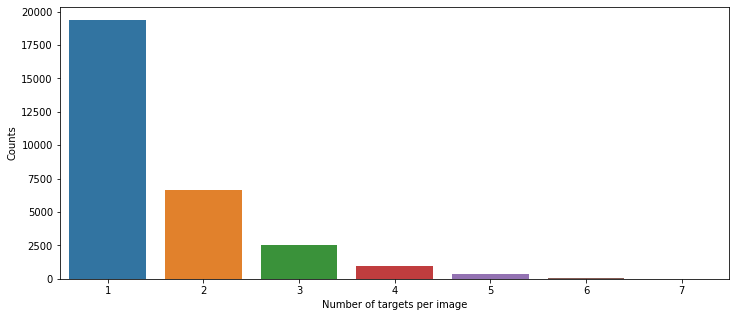

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
counts = y_train.apply(lambda x: len(x)).value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x = counts.index, y = counts.values)
plt.xlabel("Number of targets per image")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

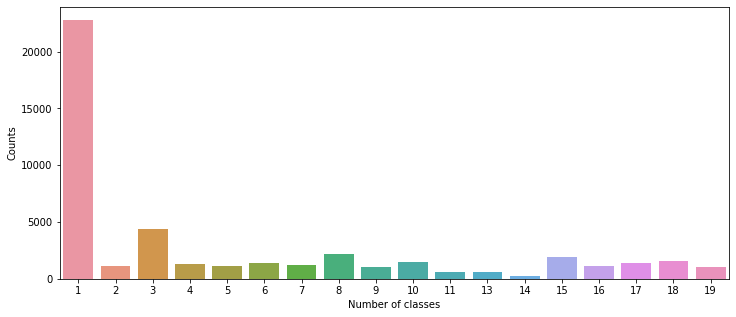

In [ ]:
from collections import Counter
plt.figure(figsize=(12, 5))
count_dict = dict(Counter(class_flatten))
sns.barplot(x = list(count_dict.keys()), y = list(count_dict.values()))
plt.xlabel("Number of classes")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

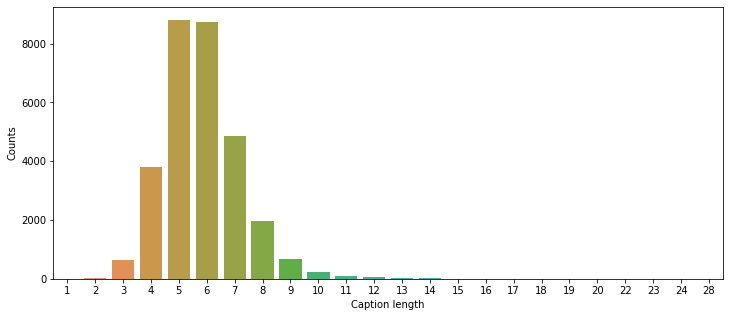

In [ ]:
# check the Caption length
caption_list = x_train["Caption"].to_list()
caption_len = [len(x) for x in caption_list]
count_caption = dict(Counter(caption_len))
plt.figure(figsize=(12, 5))
sns.barplot(x = list(count_caption.keys()), y = list(count_caption.values()))
plt.xlabel("Caption length")
plt.ylabel("Counts")

In [ ]:
class Tokenizer(nn.Module):
    def __init__(self, seq_length):
        super(Tokenizer, self).__init__()
        self.seq_length = seq_length 
        self.word_list = None
        self.word_index = None
        self.inverse_word_index = None
        self.word = None
        
    def index(self, x):
        # x: all training sentences
        self.word = x
        word_set = set() 
        for sent in x:
            for word in sent:
                word_set.add(word)

        # Normally we add the special tokens for representing the padding and unknown words separately
        # Sometimes we can also use same token to present padding and unknown words if we don't have to differentiate them
        word_set.add('[PAD]')
        word_set.add('[UNKNOWN]')

        word_list = list(word_set) 
        word_list.sort()
        self.word_list = word_list
        
        word_index = {}
        ind = 0
        for word in word_list:
            word_index[word] = ind
            ind += 1
        self.word_index = word_index
        inv_map = {v: k for k, v in word_index.items()}
        self.inverse_word_index = inv_map
        return word_list, word_index, inv_map

    def all_zeros(self, x):
        return np.count_nonzero(x) == 0

    def encode_and_add_padding(self, x):
        seq_length = self.seq_length
        word_index = self.word_index
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in x]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        elif len(temp_encoded) > seq_length:
            temp_encoded = temp_encoded[0:seq_length]
        return temp_encoded
seq_len = max(caption_len)
tokenizer = Tokenizer(seq_len)
word_list, word_index, inverse_word_index = tokenizer.index(x_train["Caption"])
x_train["Caption_encoded"] = x_train["Caption"].apply(lambda x: tokenizer.encode_and_add_padding(x))
x_test["Caption_encoded"] = x_test["Caption"].apply(lambda x: tokenizer.encode_and_add_padding(x))


In [ ]:
# https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
# https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation/notebook
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io, transform
class Text_Image_Dataset(Dataset):
    def __init__(self, image_file, text_file, target = None, img_transform = None):
        self.text_file = text_file
        self.image_file = image_file
        self.target = target
        # image transform 
        self.img_transform = img_transform

    def __len__(self):
        return len(self.image_file)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get target
        if self.target is not None:
            target = self.target.iloc[idx].to_list()
            target = torch.from_numpy(np.array(target))
        # get image
        img_name = self.image_file[idx]
        image_path = PICTURE_PATH + str(img_name)
        img = Image.fromarray(io.imread(image_path))

        if self.img_transform:
            img = self.img_transform(img)
        
        # get text
        text = torch.Tensor(self.text_file[idx]).to(torch.int64)
        # text = self.text_file[idx]
        if self.target is not None:
            sample = {'image_path':img_name, 'image': img, 'text': text, 'target': target}
        else:
            sample = {'image_path':img_name, 'image': img, 'text': text}
        return sample

# print sample
def show_image(img):
    # https://zhuanlan.zhihu.com/p/424638008
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    return 

def show_sample(dataset, idx, is_training_sample = True):
    sample = dataset[idx]
    print(sample['image_path'])
    print(sample['image'].size(), sample['image'])
    print(show_image(sample['image']))
    print(sample['text'])
    if is_training_sample:
        print(sample['target'])
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.jpg
torch.Size([3, 224, 224]) tensor([[[ 0.0227,  0.0227,  0.0227,  ...,  0.0056,  0.0056,  0.0056],
         [ 0.0227,  0.0227,  0.0227,  ...,  0.0056,  0.0056,  0.0056],
         [ 0.0227,  0.0227,  0.0227,  ...,  0.0056,  0.0056,  0.0056],
         ...,
         [-1.7240, -1.5699, -1.3302,  ..., -0.4739, -0.4226, -0.3712],
         [-1.6727, -1.4843, -1.1418,  ..., -0.4054, -0.3712, -0.4054],
         [-1.6555, -1.4158, -1.0390,  ..., -0.3541, -0.3712, -0.4739]],

        [[ 0.7829,  0.7829,  0.7829,  ...,  0.9405,  0.9405,  0.9405],
         [ 0.7829,  0.7829,  0.7829,  ...,  0.9405,  0.9405,  0.9405],
         [ 0.7829,  0.7829,  0.7829,  ...,  0.9405,  0.9405,  0.9405],
         ...,
         [-1.6331, -1.4755, -1.2304,  ..., -0.3550, -0.3025, -0.2500],
         [-1.5805, -1.3880, -1.0378,  ..., -0.2850, -0.2500, -0.2850],
         [-1.5630, -1.3179, -0.9328,  ..., -0.2325, -0.2500, -0.3550]],

        [[ 1.6291,  1.6291,  1.6291,  ...,  1.7511,  1.7511,  1.7511],
         [ 1.

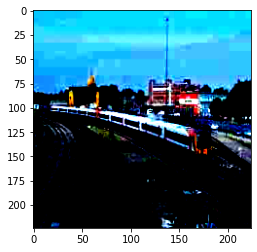

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize([224, 224]), 
        # data augmentation
        transforms.RandomHorizontalFlip(0.3),
        # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# increase robustness for prediction (without data augmentatioin step)
test_transform = transforms.Compose([
        transforms.Resize([224, 224]), 
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transformed_train_dataset = Text_Image_Dataset(image_file = x_train['ImageID'],
                                        text_file = x_train['Caption_encoded'],
                                        target = y_train_mlb,
                                        img_transform = train_transform
                                        )

transformed_test_dataset = Text_Image_Dataset(image_file = x_test['ImageID'],
                                        text_file = x_test['Caption_encoded'],
                                        img_transform = test_transform
                                        )
show_sample(transformed_train_dataset,4)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

def train_val_loader(dataset, val_ratio, batch_size):
    total_size = len(dataset)
    train_size = int(total_size * (1- val_ratio))
    test_size = int(total_size * val_ratio)

    train_set, val_set = random_split(dataset, [train_size, test_size])
    
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        num_workers=2,
        shuffle=False
    )
    return train_loader, val_loader

def test_loader(test_dataset, batch_size):
    testloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=False
    )
    return testloader

In [ ]:
BATCH_SIZE = 64
VAL_RATIO = 0.2
train_loader, val_loader = train_val_loader(transformed_train_dataset, val_ratio=VAL_RATIO, batch_size=BATCH_SIZE)
testloader = test_loader(transformed_test_dataset, BATCH_SIZE)

In [ ]:
# Pretrained Resnext50 
# https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/
from torchvision import models
class Resnext50(nn.Module):
    def __init__(self, n_class):
        super(Resnext50, self).__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        self.in_features = resnet.fc.in_features
        resnet.fc = nn.Linear(resnet.fc.in_features, n_class)
        self.base_model = resnet
        self.activation = nn.Sigmoid() 
        self.out_features = n_class
        
    def forward(self, x, is_feature_extractor = True):
        if is_feature_extractor == False:
            # act as normal pretrained Resnet model
            return self.activation(self.base_model(x))
        # act as a feature extractor
        # https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18
        self.out_features = self.in_features 
        self.base_model.fc = nn.Identity()
        features = self.base_model(x)
        return features

In [ ]:
from gensim.models import Word2Vec, FastText
class Text_Embedding(nn.Module):
    def __init__(self, word_list, training_data):
        super(Text_Embedding, self).__init__()
        # self.tokenizer = tokenizer
        self.emb_table = None
        self.training_data = training_data
        # self.model = api.load("glove-twitter-25")
        self.model = FastText(sentences=self.training_data, size=150, window=5, min_count=1, workers=4, sg=1)
        self.keys = list(self.model.wv.vocab.keys())
        # self.keys = self.model # for glove model
        self.emb_dim = self.model.vector_size

    def get_embedding(self):
        # training model
        model = self.model
        assert(model is not None)
        emb_table = []
        for i, word in enumerate(word_list):
            if word in self.keys:
                word_emb = model.wv[word] # for word2vec
                # word_emb = model[word]
                emb_table.append(word_emb)
            else:
                word_emb = [0]* self.emb_dim
                emb_table.append(word_emb)
        emb_table = np.array(emb_table)
        self.emb_table = emb_table
        return emb_table
    
training_data = x_train["Caption"].to_list()
embedding =  Text_Embedding(word_list, training_data)
emb_table = embedding.get_embedding()

In [ ]:
# model for Text
from torch.autograd import Variable
import torch.nn.functional as F
class Bi_GRU_Attention(nn.Module):
    def __init__(self, emb_table,n_hidden, n_emb):
        super(Bi_GRU_Attention, self).__init__()
        self.n_hidden = n_hidden
        self.n_emb = n_emb
        # initialize the bi-direction model
        self.emb = nn.Embedding(emb_table.shape[0],emb_table.shape[1])
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.gru = nn.GRU(emb_table.shape[1], n_hidden, batch_first = True, bidirectional=True)
        self.encoder_fc = nn.Linear(2*n_hidden, n_emb)
        self.activation = nn.ReLU()
    
    # https://colab.research.google.com/github/ngduyanhece/nlp-tutorial/blob/master/4-3.Bi-LSTM%28Attention%29/Bi_LSTM%28Attention%29_Torch.ipynb
    # output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, output, final_state):
        hidden = final_state.view(-1, self.n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1).to(device)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2).to(device)
        return context, soft_attn_weights # context : [batch_size, n_hidden * num_directions(=2)]
    
#     def forward(self, x):
#         # x should be 3 dimension [batch size, seq_len, n_features]
#         if torch.is_tensor(x) == False:
#             x = torch.Tensor(x).to(torch.int64)
#         # Get the embeded tensor
#         x = self.emb(x)
#         lstm_out, (h_n, c_n) = self.lstm(x)
#         hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
#         emb = self.activation(self.encoder_fc(hidden_out)).to(device)
#         return emb

    def forward(self, X):
        x = self.emb(X) # input : [batch_size, len_seq, embedding_dim]
        # 32, 28, 100
#         x = x.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]
        hidden_state = Variable(torch.zeros(1*2, x.shape[1], self.n_hidden)).to(device) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = Variable(torch.zeros(1*2,  x.shape[1], self.n_hidden)).to(device) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        
        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, final_hidden_state = self.gru(x)
        attn_output, attention = self.attention_net(output, final_hidden_state)
        features = self.activation(self.encoder_fc(attn_output)) # model : [batch_size, num_classes]
        return features

In [ ]:
# text_embedding_size = train_embeddings.shape[1]
class Concatenate_Embed_Model(nn.Module):
    def __init__(self, img_emb_model, text_emb_model, emb_dim, n_classes):
        super(Concatenate_Embed_Model, self).__init__()
        self.img_emb_model = img_emb_model
        self.text_emb_model = text_emb_model
        self.n_classes = n_classes
        self.emb_dim = emb_dim
        self.img_fc = None
        self.text_fc = None
        self.fc = None
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img, text, is_attention = False):
        # receive the embeddings 
        img_emb = self.img_emb_model.forward(img, is_feature_extractor = True).to(device)
        text_emb = self.text_emb_model.forward(text).to(device)
        # batch norm 
        img_norm = nn.BatchNorm1d(img_emb.shape[1]).to(device)
        text_norm = nn.BatchNorm1d(text_emb.shape[1]).to(device)
        img_emb = img_norm(img_emb).to(device)
        text_emb = text_norm(text_emb).to(device)
        img_emb_dim = img_emb.shape[1]
        text_emb_dim = text_emb.shape[1] 
            
        if self.img_fc is None:
            # transform embedding to specific embedding dimension
            self.img_fc = nn.Sequential(nn.Linear(img_emb.shape[1], 256),
                                        nn.ReLU(),
                                        nn.Linear(256, self.emb_dim)
                                       ).to(device)
                            
            self.text_fc = nn.Sequential(nn.Linear(text_emb.shape[1], 256),
                                        nn.ReLU(),
                                        nn.Linear(256, self.emb_dim)
                                       ).to(device)
            
        img_emb = self.img_fc(img_emb).to(device)
        text_emb = self.text_fc(text_emb).to(device)
    
                
        if is_attention == False:
            if self.fc is None:
                self.fc =  nn.Sequential(
                                nn.Linear(2* self.emb_dim, 512),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(512, self.n_classes)
                                ).to(device)
            concate_emb = torch.cat((img_emb,text_emb), 1).to(device)
            output_before_sigmoid = self.fc(concate_emb).to(device)
            output = self.sigmoid(output_before_sigmoid).to(device)
            return output_before_sigmoid, output
    

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

def train_iter(log_interval, model, optimizer, loss_func, img, text_inputs, target):
    '''
    Train the model for a single iteration.
    An iteration is when a single batch of data is passed forward and 
    backward through the neural network.
    '''
    optimizer.zero_grad()  # Zero out the old gradients (so we only use new gradients for a new update iteration).
    output_before_sigmoid, output = model(img, text_inputs)  # Forward the data through the model.
    if loss_func.__class__.__name__ == 'BCELoss':
        loss = loss_func(output, target.float())  # Calculate the loss 
    else:
        loss = loss_func(output_before_sigmoid, target.float())
    loss.backward()  # Backward the loss and calculate gradients for parameters.
    optimizer.step()  # Update the parameters.
    return loss

def no_prediction(pred, output):
    for i in range(pred.shape[0]):
        if np.all(pred[i,] == 0):
            argmax_label = np.argmax(output[i,])
            pred[i, argmax_label] = 1
    return pred

def validation(model, device, val_loader, loss_func, threshold):
    '''
    Testing the model on the entire test set.
    '''
    model.eval()  # Switch the model to evaluation mode, which prevents the dropout behavior.
    val_loss = 0
    correct = 0
    # n = 1
    all_preds = None
    all_targets = None
    with torch.no_grad():  
        for sample in val_loader:  
            img = sample['image'].to(device)
            text_inputs = sample['text'].to(device)
            target = sample['target'].to(device)
            output_before_sigmoid, output = model(img, text_inputs)  
            pred = np.where(output.cpu().data.numpy() >= threshold, 1, 0)
            # pred = no_prediction(pred, output.cpu().data.numpy())
            # if n == 2:
            #     print("output", output)
            #     print("pred", pred)
            #     print("target", target)
            # n+=1
            if all_preds is None:
                all_preds = pred
                all_targets = target.cpu().data.numpy()
            else:
                all_preds = np.concatenate((all_preds, pred), axis=0)
                all_targets = np.concatenate((all_targets, target.cpu().data.numpy()), axis=0)
            val_loss += target.size(0)* loss_func(output, target.float()).item() # Sum up batch loss
            correct += accuracy_score(target.cpu().data.numpy(), pred) * target.size(0)  # Count the correct predictions.
    f1score = f1_score(all_targets, all_preds, average='samples')
    val_loss /= len(val_loader.dataset)  # Average the loss on the entire testing set.
    print(classification_report(all_targets, all_preds))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n, F1 score: {:.4f}'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset),
        f1score))
    
    return f1score

def train_epoch(log_interval, model, train_loader, optimizer, epoch, loss_func):
    '''
    Train the model for an epoch.
    An epoch is when the entire dataset is passed forward and 
    backward through the neural network for once.
    The number of batches in a dataset is equal to number of iterations for one epoch.
    '''
    start_time = time.time()
    model.train()
    train_loss_batch = 0
    for batch_idx, sample in enumerate(train_loader):  
        img = sample['image'].to(device)
        text_inputs = sample['text'].to(device)
        target = sample['target'].to(device)
        loss = train_iter(log_interval, model, optimizer, loss_func, img, text_inputs, target)
        train_loss_batch += loss.item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Time: {: 2f}'.format(
                epoch, batch_idx * len(target), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                time.time() - start_time))
    return train_loss_batch/len(train_loader)

def test_pred(model, testloader, threshold):
    model.eval()
    img_paths = []
    pred_labels = []
    with torch.no_grad():  # Because this is testing and no optimization is required, the gradients are not needed.
        for batch, sample in enumerate(testloader):  # Iterate through the entire test set.
            img = sample['image'].to(device)
            text_inputs = sample['text'].to(device)
            path = sample['image_path']
            img_paths.extend(path)
            output_before_sigmoid, output = model(img, text_inputs)  # Forward the data through the model.
            pred = np.where(output.cpu().data.numpy() >= threshold, 1, 0)
            # pred = no_prediction(pred, output.cpu().data.numpy() )
            for line in pred:
                label_list = [str(x+1) for x in range(len(line)) if line[x]== 1]
                labels = ' '.join(label_list)
                pred_labels.append(labels)            
    assert(len(img_paths) == len(pred_labels))
    submission_df = pd.DataFrame({'ImageID': img_paths, 'Labels': pred_labels})
    return submission_df

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
img_model = Resnext50(num_class).to(device)
# img_model = DenseNet121(num_class).to(device)
gpu_usage() 
# text_model = Bi_LSTM_Attention(emb_table, 256, n_emb = 2048).to(device)
n_hidden = 128
text_model = Bi_GRU_Attention(emb_table, n_hidden, n_emb = 256).to(device)
gpu_usage() 
n_emb = 256
model = Concatenate_Embed_Model(img_model, text_model, n_emb, num_class).to(device)
gpu_usage() 
print('Model initialized.')

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

| ID | GPU | MEM |
------------------
|  0 |  5% |  6% |
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |
Model initialized.


In [ ]:
# from torch.optim.lr_scheduler import StepLR
n_epochs = 15
log_interval = 50
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

criterion = nn.BCELoss()
train_loss = []
best_f1_score = -float("inf") # record the best loss to get the best model

for epoch in range(n_epochs):
    loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
    train_loss.append(loss)
    f1score = validation(model, device, val_loader, criterion, 0.5)

    # https://www.kaggle.com/general/178486
    if f1score > best_f1_score:
        best_f1_score = f1score
        es = 0
        torch.save(model, "model.pt")
    else:
        es += 1
        print("Counter {} of 3".format(es))

        if es >= 3:
            print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
            break

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.586949 	 Time:  2.566388
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.121897 	 Time:  75.332726
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.119246 	 Time:  147.832104
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.071525 	 Time:  220.113331
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.096505 	 Time:  292.507978
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.087353 	 Time:  364.853069
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.068662 	 Time:  437.155896
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.084889 	 Time:  509.618891
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4539
           1       1.00      0.00      0.01       231
           2       0.73      0.24      0.36       846
           3       0.86      0.64      0.73       252
           4       0.99      0.92      0.95       236
           5       0.97      0.67      0.80       269
           6       0.97      0.85      0.91       244
           7      

In [ ]:
best_model = torch.load("default_model.pt")

In [ ]:
testloader = test_loader(transformed_test_dataset, 20)
submission_df = test_pred(best_model, testloader, 0.5)
submission_df.to_csv('submission_gru_attention_Resnext50_v2.csv', index=False)  

In [ ]:
best_f1_score

0.8645395622895623

### No need to run the below code for training and generating test file, it is for hyperparameter testing and ablation studies


# Experiment

default model

- learning rate: 3e-4
- number of hidden nodes: 128
- word embedding dimension: 150
- batch size: 64
- with attention on the text embedding
- with text embedding type: fast text

## Hyperparameter analysis

# default model

In [ ]:
def default_model():
  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, "default_model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break

  return best_f1_score

In [ ]:
import time
start = time.time()
default_f1_score = default_model()
end = time.time()

default_model_time = end-start

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.610882 	 Time:  1.437355
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.170946 	 Time:  25.996942
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.132523 	 Time:  50.943444
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.106274 	 Time:  76.323701
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.123204 	 Time:  100.874357
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.088359 	 Time:  125.426718
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.096608 	 Time:  149.975013
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.102495 	 Time:  174.558320
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4537
           1       0.00      0.00      0.00       228
           2       0.69      0.54      0.60       917
           3       0.80      0.62      0.70       221
           4       0.99      0.93      0.96       223
           5       0.96      0.70      0.81       291
           6       0.97      0.87      0.92       250
           7       0

In [ ]:
default_f1_score

In [ ]:
default_model_time

2339.5213434696198

### Learning rate

In [ ]:
def lr_tuning (lr = 3e-4):
  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = lr
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, str(lr)+"model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break
  return best_f1_score

In [ ]:


lr_3e_3 = lr_tuning(3e-3) 

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.061283 	 Time:  1.484229
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.130603 	 Time:  27.614033
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.093887 	 Time:  52.597935
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.095244 	 Time:  76.685468
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.090957 	 Time:  100.900410
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.085600 	 Time:  125.233398
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.056732 	 Time:  149.307569
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.101464 	 Time:  173.376546
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      4571
           1       1.00      0.03      0.05       229
           2       0.73      0.12      0.20       878
           3       0.99      0.65      0.79       263
           4       0.98      0.85      0.91       204
           5       0.95      0.65      0.77       270
           6       0.95      0.56      0.70       246
           7       0

In [ ]:
lr_3e_2 = lr_tuning(3e-2)

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.568872 	 Time:  1.022168
Train Epoch: 0 [3200/24000 (13%)]	Loss: 5.345395 	 Time:  25.238584
Train Epoch: 0 [6400/24000 (27%)]	Loss: 5.509869 	 Time:  49.349750
Train Epoch: 0 [9600/24000 (40%)]	Loss: 5.180921 	 Time:  73.482382
Train Epoch: 0 [12800/24000 (53%)]	Loss: 5.756579 	 Time:  97.610274
Train Epoch: 0 [16000/24000 (67%)]	Loss: 5.838816 	 Time:  121.743311
Train Epoch: 0 [19200/24000 (80%)]	Loss: 4.851974 	 Time:  145.873258
Train Epoch: 0 [22400/24000 (93%)]	Loss: 5.427632 	 Time:  170.030422
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4607
           1       0.00      0.00      0.00       224
           2       0.00      0.00      0.00       871
           3       0.00      0.00      0.00       243
           4       0.00      0.00      0.00       223
           5       0.00      0.00      0.00       271
           6       0.00      0.00      0.00       211
           7       0.

In [ ]:
lr_list = [3e-4, 3e-3, 3e-2]
lr_dict = {}
lr_dict['learning rate'] = lr_list
lr_dict['f1 score'] = [default_f1_score, lr_3e_3, lr_3e_2]
lr_dict['model size'] = [default_model_size, 96.36, 96.36]

import pandas as pd
lr_df = pd.DataFrame.from_dict(lr_dict)
lr_df['f1 score'] = round(lr_df['f1 score'],3)
lr_df

,learning rate,f1 score,model size
0,0.0003,0.871,96.36
1,0.0030,0.801,96.36
2,0.0300,0.649,96.36


Text(0, 0.5, 'f1 score')

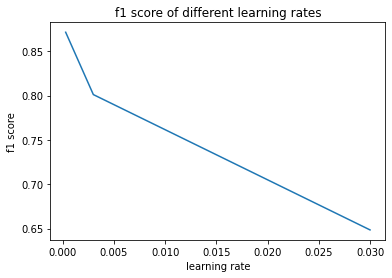

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lr_df['learning rate'], lr_df['f1 score'])
plt.title("f1 score of different learning rates")
plt.xlabel("learning rate")
plt.ylabel("f1 score")

# hidden dimension

In [ ]:
def n_hidden_tuning (n_hidden = 128):

  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  img_model = Resnext50(num_class).to(device)
  # img_model = DenseNet121(num_class).to(device)
  gpu_usage() 
  # text_model = Bi_LSTM_Attention(emb_table, 256, n_emb = 2048).to(device)
  n_hidden = n_hidden
  text_model = Bi_GRU_Attention(emb_table, n_hidden, n_emb = 256).to(device)
  gpu_usage() 
  n_emb = 256
  model = Concatenate_Embed_Model(img_model, text_model, n_emb, num_class).to(device)
  gpu_usage() 
  print('Model initialized.')

  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, str(n_hidden)+"model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break
  return best_f1_score

In [ ]:
n_hidden_list = [32, 64, 128]

n_hidden_32 = n_hidden_tuning(32)

| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.683889 	 Time:  1.106834
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.594692 	 Time:  25.169781
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.587987 	 Time:  49.424859
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.573744 	 Time:  73.521507
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.575863 	 Time:  97.593418
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.577518 	 Time:  121.688796
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.574601 	 Time:  146.181824
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.573209 	 Time:  170.317933
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4607
           1       0.03      0.02      0.02       224
           2       0.41      0.39      0.40       871
           3       0.00      0.00      0.00    

In [ ]:
n_hidden_32 = 0.5776

In [ ]:
n_hidden_64 = n_hidden_tuning(64)

| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.690795 	 Time:  1.219042
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.608334 	 Time:  25.928183
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.604082 	 Time:  50.244909
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.594228 	 Time:  74.287362
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.593457 	 Time:  98.517852
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.588798 	 Time:  122.865381
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.590519 	 Time:  146.960907
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.587410 	 Time:  171.363304
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4607
           1       0.00      0.00      0.00       224
           2       0.47      0.31      0.38       871
           3       0.22      0.05      0.09    

In [ ]:
n_hidden_dict_df = {}
n_hidden_dict_df['hidden dimension'] = n_hidden_list
n_hidden_dict_df['f1 score'] = [n_hidden_32, n_hidden_64, default_f1_score]
n_hidden_dict_df['model size'] = [95.49, 95.73, 96.36]

n_hidden_df = pd.DataFrame.from_dict(n_hidden_dict_df)
n_hidden_df['f1 score'] = round(n_hidden_df['f1 score'],3)
n_hidden_df

,hidden dimension,f1 score,model size
0,32,0.655,95.49
1,64,0.646,95.73
2,128,0.871,96.36


Text(0, 0.5, 'f1 score')

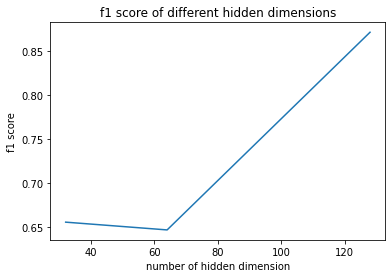

In [ ]:
import matplotlib.pyplot as plt

plt.plot(n_hidden_df['hidden dimension'], n_hidden_df['f1 score'])
plt.title("f1 score of different hidden dimensions")
plt.xlabel("number of hidden dimension")
plt.ylabel("f1 score")

# word embedding dimension

In [ ]:
def word_emb_dim_tuning(emb_dim = 150):

  from gensim.models import Word2Vec, FastText
  class Text_Embedding(nn.Module):
      def __init__(self, word_list, training_data):
          super(Text_Embedding, self).__init__()
          # self.tokenizer = tokenizer
          self.emb_table = None
          self.training_data = training_data
          # self.model = api.load("glove-twitter-25")
          self.model = FastText(sentences=self.training_data, size=emb_dim, window=5, min_count=1, workers=4, sg=1)
          self.keys = list(self.model.wv.vocab.keys())
          # self.keys = self.model # for glove model
          self.emb_dim = self.model.vector_size

      def get_embedding(self):
          # training model
          model = self.model
          assert(model is not None)
          emb_table = []
          for i, word in enumerate(word_list):
              if word in self.keys:
                  word_emb = model.wv[word] # for word2vec
                  # word_emb = model[word]
                  emb_table.append(word_emb)
              else:
                  word_emb = [0]* self.emb_dim
                  emb_table.append(word_emb)
          emb_table = np.array(emb_table)
          self.emb_table = emb_table
          return emb_table
      
  training_data = x_train["Caption"].to_list()
  embedding =  Text_Embedding(word_list, training_data)
  emb_table = embedding.get_embedding()

  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  img_model = Resnext50(num_class).to(device)
  # img_model = DenseNet121(num_class).to(device)
  gpu_usage() 
  # text_model = Bi_LSTM_Attention(emb_table, 256, n_emb = 2048).to(device)
  n_hidden = 128
  text_model = Bi_GRU_Attention(emb_table, n_hidden, n_emb = 256).to(device)
  gpu_usage() 
  n_emb = 256
  model = Concatenate_Embed_Model(img_model, text_model, n_emb, num_class).to(device)
  gpu_usage() 
  print('Model initialized.')

  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, 'word_emb'+str(emb_dim)+"model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break

  return best_f1_score

In [ ]:
word_emb_dim = [50, 100, 150]

word_emb_50 = word_emb_dim_tuning(50)

| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.693250 	 Time:  1.701497
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.605086 	 Time:  26.745268
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.596005 	 Time:  50.761876
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.595074 	 Time:  75.125317
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.589391 	 Time:  99.156192
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.592983 	 Time:  123.245176
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.587870 	 Time:  147.295753
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.588488 	 Time:  171.419008
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4607
           1       0.00      0.00      0.00       224
           2       0.30      0.58      0.40       871
           3       0.02      0.03      0.02    

In [ ]:
word_emb_50

0.6518322751322752

In [ ]:
word_emb_100 = word_emb_dim_tuning(100)

| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.695126 	 Time:  2.121323
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.606610 	 Time:  27.768179
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.600983 	 Time:  51.945139
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.600595 	 Time:  76.057237
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.595872 	 Time:  100.450124
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.591609 	 Time:  124.551430
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.596393 	 Time:  148.758499
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.597076 	 Time:  172.911099
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4607
           1       0.07      0.12      0.09       224
           2       0.53      0.13      0.20       871
           3       0.00      0.00      0.00   

In [ ]:
word_emb_dim_dict = {}
word_emb_dim_dict['word embedding dimension'] = word_emb_dim
word_emb_dim_dict['f1 score'] = [word_emb_50, word_emb_100, default_f1_score]
word_emb_dim_dict['model size'] = [93.77, 95.06, 96.36]

word_emb_dim_df = pd.DataFrame.from_dict(word_emb_dim_dict)
word_emb_dim_df['f1 score'] = round(word_emb_dim_df['f1 score'],3)
word_emb_dim_df

,word embedding dimension,f1 score,model size
0,50,0.652,93.77
1,100,0.530,95.06
2,150,0.871,96.36


Text(0, 0.5, 'f1 score')

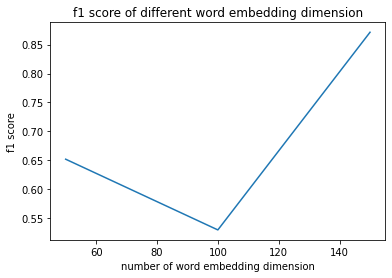

In [ ]:
plt.plot(word_emb_dim_df['word embedding dimension'], word_emb_dim_df['f1 score'])
plt.title("f1 score of different word embedding dimension")
plt.xlabel("number of word embedding dimension")
plt.ylabel("f1 score")

# batch size

In [ ]:
def batch_size_tuning(batch_size = 64):
  BATCH_SIZE = batch_size
  train_loader, val_loader = train_val_loader(transformed_train_dataset, val_ratio=VAL_RATIO, batch_size=BATCH_SIZE)
  testloader = test_loader(transformed_test_dataset, BATCH_SIZE)

  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, 'batch_size'+str(batch_size)+"model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break

  return best_f1_score

In [ ]:
batch_size_list = [32, 64, 128]

batch_size_32 = batch_size_tuning(32)

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.693025 	 Time:  1.847053
Train Epoch: 0 [1600/24000 (7%)]	Loss: 0.619556 	 Time:  17.515766
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.602605 	 Time:  30.942487
Train Epoch: 0 [4800/24000 (20%)]	Loss: 0.599909 	 Time:  44.341965
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.596458 	 Time:  57.711319
Train Epoch: 0 [8000/24000 (33%)]	Loss: 0.594303 	 Time:  71.223948
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.599688 	 Time:  84.703373
Train Epoch: 0 [11200/24000 (47%)]	Loss: 0.598291 	 Time:  98.770356
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.594169 	 Time:  112.277912
Train Epoch: 0 [14400/24000 (60%)]	Loss: 0.595299 	 Time:  127.197708
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.595387 	 Time:  140.675279
Train Epoch: 0 [17600/24000 (73%)]	Loss: 0.589602 	 Time:  154.177680
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.593144 	 Time:  167.702727
Train Epoch: 0 [20800/24000 (87%)]	Loss: 0.593338 	 Time:  181.174728
Train Epoch: 0 [22400/24000 (93%)]	Loss: 

In [ ]:
batch_size_128 = batch_size_tuning(128)

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.584645 	 Time:  2.578530
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.145243 	 Time:  49.782960
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.089360 	 Time:  96.661785
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.100776 	 Time:  143.655802
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4550
           1       1.00      0.02      0.03       245
           2       0.61      0.43      0.51       857
           3       0.93      0.65      0.77       266
           4       0.97      0.95      0.96       199
           5       0.94      0.64      0.76       291
           6       0.95      0.89      0.92       227
           7       0.85      0.34      0.48       467
           8       0.94      0.57      0.71       218
           9       0.84      0.24      0.38       302
          10       1.00      0.59      0.74       123
          11       0.00      0.00      0.00         0
          12       0.97    

In [ ]:
batch_size__dict = {}
batch_size__dict['batch size'] = batch_size_list
batch_size__dict['f1 score'] = [batch_size_32, default_f1_score, batch_size_128]
batch_size__dict['model size'] = [96.36, 96.36, 96.36]

batch_size_df = pd.DataFrame.from_dict(batch_size__dict)
batch_size_df['f1 score'] = round(batch_size_df['f1 score'],3)
batch_size_df

,batch size,f1 score,model size
0,32,0.656,96.36
1,64,0.871,96.36
2,128,0.867,96.36


Text(0, 0.5, 'f1 score')

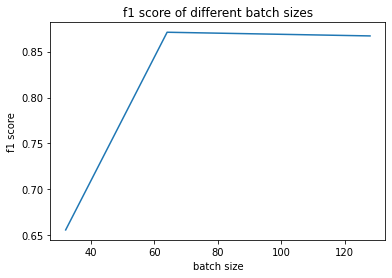

In [ ]:
plt.plot(batch_size_df['batch size'], batch_size_df['f1 score'])
plt.title("f1 score of different batch size")
plt.xlabel("batch size")
plt.ylabel("f1 score")

# word embedding

In [ ]:
def word_emb_dim_tuning(cbow=False, skipgram=False):

  from gensim.models import Word2Vec, FastText
  class Text_Embedding(nn.Module):
      def __init__(self, word_list, training_data):
          super(Text_Embedding, self).__init__()
          # self.tokenizer = tokenizer
          self.emb_table = None
          self.training_data = training_data
          # self.model = api.load("glove-twitter-25")
          if cbow == True:
            self.model = Word2Vec(sentences=self.training_data, size=150, window=5, min_count=1, workers=4, sg=0)
          if skipgram == True:
            self.model = Word2Vec(sentences=self.training_data, size=150, window=5, min_count=1, workers=4, sg=1)
          self.keys = list(self.model.wv.vocab.keys())
          # self.keys = self.model # for glove model
          self.emb_dim = self.model.vector_size

      def get_embedding(self):
          # training model
          model = self.model
          assert(model is not None)
          emb_table = []
          for i, word in enumerate(word_list):
              if word in self.keys:
                  word_emb = model.wv[word] # for word2vec
                  # word_emb = model[word]
                  emb_table.append(word_emb)
              else:
                  word_emb = [0]* self.emb_dim
                  emb_table.append(word_emb)
          emb_table = np.array(emb_table)
          self.emb_table = emb_table
          return emb_table
      
  training_data = x_train["Caption"].to_list()
  embedding =  Text_Embedding(word_list, training_data)
  emb_table = embedding.get_embedding()

  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  img_model = Resnext50(num_class).to(device)
  # img_model = DenseNet121(num_class).to(device)
  gpu_usage() 
  # text_model = Bi_LSTM_Attention(emb_table, 256, n_emb = 2048).to(device)
  n_hidden = 128
  text_model = Bi_GRU_Attention(emb_table, n_hidden, n_emb = 256).to(device)
  gpu_usage() 
  n_emb = 256
  model = Concatenate_Embed_Model(img_model, text_model, n_emb, num_class).to(device)
  gpu_usage() 
  print('Model initialized.')

  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          if cbow==True:
            torch.save(model, "cbow_model.pt")
          if skipgram==True:
            torch.save(model, "skipgram_model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break

  return best_f1_score

In [ ]:
cbow_model = word_emb_dim_tuning(cbow=True, skipgram=False)

| ID | GPU | MEM |
------------------
|  0 |  1% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  1% | 59% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 59% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.695941 	 Time:  1.128481
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.616993 	 Time:  25.228561
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.607876 	 Time:  49.230968
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.607904 	 Time:  73.241834
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.601604 	 Time:  97.305757
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.603696 	 Time:  121.328594
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.600378 	 Time:  145.361748
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.603328 	 Time:  169.402500
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4526
           1       0.00      0.00      0.00       222
           2       0.50      0.27      0.35       890
           3       0.00      0.00      0.00    

In [ ]:
skipgram_model = word_emb_dim_tuning(cbow=False, skipgram=True)

| ID | GPU | MEM |
------------------
|  0 |  0% | 60% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 60% |
| ID | GPU | MEM |
------------------
|  0 |  5% | 60% |
Model initialized.
Train Epoch: 0 [0/24000 (0%)]	Loss: 0.690644 	 Time:  1.006032
Train Epoch: 0 [3200/24000 (13%)]	Loss: 0.604151 	 Time:  25.023249
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.594438 	 Time:  49.056904
Train Epoch: 0 [9600/24000 (40%)]	Loss: 0.594814 	 Time:  73.066408
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.594251 	 Time:  97.084569
Train Epoch: 0 [16000/24000 (67%)]	Loss: 0.589498 	 Time:  121.120754
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.588189 	 Time:  145.162687
Train Epoch: 0 [22400/24000 (93%)]	Loss: 0.586243 	 Time:  169.168890
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      4526
           1       0.07      0.36      0.12       222
           2       0.59      0.23      0.34       890
           3       0.00      0.00      0.00    

In [ ]:
def fasttext_cbow_model():
  # from torch.optim.lr_scheduler import StepLR
  n_epochs = 15
  log_interval = 50
  lr = 3e-4
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  criterion = nn.BCELoss()
  train_loss = []
  best_f1_score = -float("inf") # record the best loss to get the best model

  for epoch in range(n_epochs):
      loss = train_epoch(log_interval, model, train_loader, optimizer, epoch, criterion)
      train_loss.append(loss)
      f1score = validation(model, device, val_loader, criterion, 0.5)

      # https://www.kaggle.com/general/178486
      if f1score > best_f1_score:
          best_f1_score = f1score
          es = 0
          torch.save(model, "default_model.pt")
      else:
          es += 1
          print("Counter {} of 3".format(es))

          if es >= 3:
              print("Early stopping with best loss: ", loss, "and val_acc for this epoch: ", f1score)
              break

  return best_f1_score